<a href="https://colab.research.google.com/github/qubvel/transformers-notebooks/blob/main/notebooks/DAB_DETR_finetune_on_a_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning DAB-DETR on a custom dataset

Object detection is the computer vision task of detecting instances (such as humans, buildings, or cars) in an image. Object detection models receive an image as input and output coordinates of the bounding boxes and associated class labels of the detected objects. An image can contain multiple objects,
each with its own bounding box and a label (e.g. it can have a car and a building), and each object can be present in different parts of an image (e.g. the image can have several cars). See also the [object detection task page](https://huggingface.co/tasks/object-detection) on Hugging Face.

This task is commonly used in autonomous driving for detecting things like pedestrians, road signs, and traffic lights.
Other applications include counting objects in images, image search, and more.

In this guide, you will learn how to:

 1. Finetune [DAB-DETR](https://huggingface.co/docs/transformers/main/en/model_doc/dab-detr), a model that combines a convolutional
 backbone with an encoder-decoder Transformer, on the [CPPE-5](https://huggingface.co/datasets/cppe-5)
 dataset.
 2. Use your finetuned model for inference.

## Set-up environment

First let's install the necessary libraries. We'll use:

* 🤗 Datasets to load a dataset from the Hugging Face Hub (or to create your own custom one)
* 🤗 Transformers and 🤗 Accelerate to train your model
* `albumentations` to augment the data
* torchmetrics for computing mAP (mean average-precision) during training.

In [ ]:
!pip install uv

# Latests transformers + vision libraries
!uv pip install --system -q -U git+https://github.com/huggingface/transformers
!uv pip install --system -q -U timm torchvision Pillow numpy==1.*

# For training
!uv pip install --system -q -U datasets accelerate
!uv pip install --system -q -U "albumentations==1.4.6" torchmetrics

To get started, we'll define global constants, namely the model checkpoint and image size. Feel free to select other pretrained checkpoint available on the [hub](https://huggingface.co/PekingU).

In [ ]:
checkpoint = "IDEA-Research/dab-detr-resnet-50-dc5"
image_size = 480

## Load dataset

Next we'll load the dataset on which we'd like to fine-tune DAB-DETR.

In case of a custom object detection dataset, I'd recommend the guide [here](https://huggingface.co/docs/datasets/image_dataset#object-detection). Here we load an existing dataset from the hub, namely [CPPE-5](https://huggingface.co/datasets/cppe-5) which contains images with annotations identifying medical personal protective equipment (PPE) in the context of the COVID-19 pandemic.

Start by loading the dataset and creating a `validation` split from `train`:

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cppe-5")

if "validation" not in dataset:
    split = dataset["train"].train_test_split(0.15, seed=1337)
    dataset["train"] = split["train"]
    dataset["validation"] = split["test"]

dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 850
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 150
    })
})

You'll see that this dataset has 1000 images for train and validation sets and a test set with 29 images.

To get familiar with the data, explore what the examples look like.

In [ ]:
dataset["train"][0]

{'image_id': 366,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=500x290>,
 'width': 500,
 'height': 500,
 'objects': {'id': [1932, 1933, 1934],
  'area': [27063, 34200, 32431],
  'bbox': [[29.0, 11.0, 97.0, 279.0],
   [201.0, 1.0, 120.0, 285.0],
   [382.0, 0.0, 113.0, 287.0]],
  'category': [0, 0, 0]}}

The examples in the dataset have the following fields:
- `image_id`: the example image id
- `image`: a `PIL.Image.Image` object containing the image
- `width`: width of the image
- `height`: height of the image
- `objects`: a dictionary containing bounding box metadata for the objects in the image:
  - `id`: the annotation id
  - `area`: the area of the bounding box
  - `bbox`: the object's bounding box (in the [COCO format](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#coco) )
  - `category`: the object's category, with possible values including `Coverall (0)`, `Face_Shield (1)`, `Gloves (2)`, `Goggles (3)` and `Mask (4)`

You may notice that the `bbox` field follows the COCO format, which is the format that the DAB-DETR model expects.
However, the grouping of the fields inside `objects` differs from the annotation format DAB-DETR requires. You will
need to apply some preprocessing transformations before using this data for training.

To get an even better understanding of the data, visualize an example in the dataset.

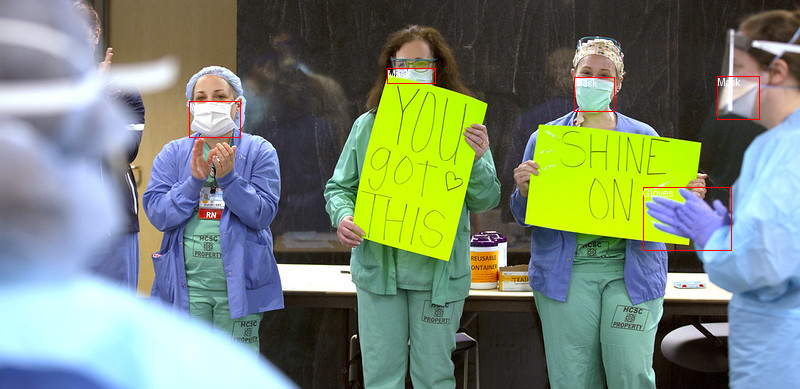

In [ ]:
import numpy as np
from PIL import Image, ImageDraw

# Get mapping from category id to category name
categories = dataset["train"].features["objects"].feature["category"].names
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

# Load image and annotations
image = dataset["train"][2]["image"]
annotations = dataset["train"][2]["objects"]

# Draw bounding boxes and labels
draw = ImageDraw.Draw(image)
for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

To visualize the bounding boxes with associated labels, you can get the labels from the dataset's metadata, specifically
the `category` field.
You'll also want to create dictionaries that map a label id to a label class (`id2label`) and the other way around (`label2id`).
You can use them later when setting up the model. Including these maps will make your model reusable by others if you share
it on the Hugging Face Hub. Please note that, the part of above code that draws the bounding boxes assume that it is in `COCO` format `(x_min, y_min, width, height)`. It has to be adjusted to work for other formats like `(x_min, y_min, x_max, y_max)`.

As a final step of getting familiar with the data, explore it for potential issues. One common problem with datasets for
object detection is bounding boxes that "stretch" beyond the edge of the image. Such "runaway" bounding boxes can raise
errors during training and should be addressed. There are a few examples with this issue in this dataset.
To keep things simple in this guide, we will set `clip=True` for `BboxParams` in transformations below.

## Preprocess the data

To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model.
[AutoImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing image data to create `pixel_values`, `pixel_mask`, and
`labels` that a DETR model can train with. The image processor has some attributes that you won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. These values are crucial
to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [ ]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(
    checkpoint,
    do_resize=True,
    size={"width": image_size, "height": image_size},
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Before passing the images to the `image_processor`, apply two preprocessing transformations to the dataset:
- Augmenting images
- Reformatting annotations to meet DAB-DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use [Albumentations](https://albumentations.ai/docs/).
This library ensures that transformations affect the image and update the bounding boxes accordingly.
The 🤗 Datasets library documentation has a detailed [guide on how to augment images for object detection](https://huggingface.co/docs/datasets/object_detection),
and it uses the exact same dataset as an example. Apply the same approach here, resize each image,
flip it horizontally, and brighten it. For additional augmentation options, explore the [Albumentations Demo Space](https://huggingface.co/spaces/qubvel-hf/albumentations-demo).

In [ ]:
import albumentations as A

train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=25, min_width=1, min_height=1),
)

# to make sure boxes are clipped to image size and there is no boxes with area < 1 pixel
validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=1, min_width=1, min_height=1),
)

Visualize some augmented images to make sure images look natural and annotations are correct:

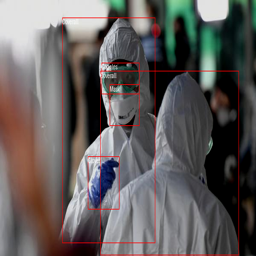

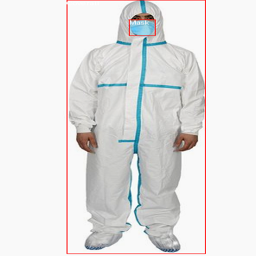

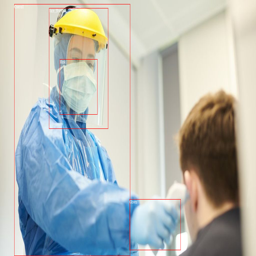

In [ ]:
for i in [15, 16, 17]:
    image = dataset["train"][i]["image"]
    annotations = dataset["train"][i]["objects"]

    # Apply the augmentation
    output = train_augmentation_and_transform(image=np.array(image), bboxes=annotations["bbox"], category=annotations["category"])

    # Unpack the output
    image = Image.fromarray(output["image"])
    categories, boxes = output["category"], output["bboxes"]

    # Draw the augmented image
    draw = ImageDraw.Draw(image)
    for category, box in zip(categories, boxes):
        x, y, w, h = box
        draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
        draw.text((x, y), id2label[category], fill="white")

    display(image.resize([256, 256]))

The `image_processor` expects the annotations to be in the following format: `{'image_id': int, 'annotations': List[Dict]}`,
 where each dictionary is a COCO object annotation. Let's add a function to reformat annotations for a single example:

In [ ]:
from torch.utils.data import Dataset


class CPPE5Dataset(Dataset):
    def __init__(self, dataset, image_processor, transform=None):
        self.dataset = dataset
        self.image_processor = image_processor
        self.transform = transform

    @staticmethod
    def format_image_annotations_as_coco(image_id, categories, boxes):
        """Format one set of image annotations to the COCO format

        Args:
            image_id (str): image id. e.g. "0001"
            categories (List[int]): list of categories/class labels corresponding to provided bounding boxes
            boxes (List[Tuple[float]]): list of bounding boxes provided in COCO format
                ([center_x, center_y, width, height] in absolute coordinates)

        Returns:
            dict: {
                "image_id": image id,
                "annotations": list of formatted annotations
            }
        """
        annotations = []
        for category, bbox in zip(categories, boxes):
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": list(bbox),
                "iscrowd": 0,
                "area": bbox[2] * bbox[3],
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        image_id = sample["image_id"]
        image = sample["image"]
        boxes = sample["objects"]["bbox"]
        categories = sample["objects"]["category"]

        # Convert image to RGB numpy array
        image = np.array(image.convert("RGB"))

        # Apply augmentations
        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, category=categories)
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]

        # Format annotations in COCO format for image_processor
        formatted_annotations = self.format_image_annotations_as_coco(image_id, categories, boxes)

        # Apply the image processor transformations: resizing, rescaling, normalization
        result = self.image_processor(
            images=image, annotations=formatted_annotations, return_tensors="pt"
        )

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

Now you can combine the image and annotation transformations to use on a batch of examples:

In [ ]:
train_dataset = CPPE5Dataset(dataset["train"], image_processor, transform=train_augmentation_and_transform)
validation_dataset = CPPE5Dataset(dataset["validation"], image_processor, transform=validation_transform)
test_dataset = CPPE5Dataset(dataset["test"], image_processor, transform=validation_transform)

train_dataset[15]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'pixel_values': tensor([[[ 1.8037,  1.8208,  1.8550,  ..., -0.7479, -0.6794, -0.6281],
          [ 1.8208,  1.8379,  1.8722,  ..., -0.7650, -0.6965, -0.6452],
          [ 1.8379,  1.8722,  1.8893,  ..., -0.7822, -0.7137, -0.6623],
          ...,
          [ 0.6392,  0.6221,  0.5878,  ..., -1.7754, -1.8097, -1.8097],
          [ 0.6049,  0.5878,  0.5536,  ..., -1.5870, -1.6213, -1.6384],
          [ 0.5878,  0.5707,  0.5364,  ..., -1.4500, -1.4843, -1.5014]],
 
         [[ 1.9734,  1.9909,  2.0259,  ...,  0.6954,  0.8354,  0.9580],
          [ 1.9909,  2.0084,  2.0434,  ...,  0.6779,  0.8179,  0.9405],
          [ 2.0084,  2.0434,  2.0609,  ...,  0.6604,  0.8004,  0.9230],
          ...,
          [ 0.8004,  0.7829,  0.7479,  ..., -1.6506, -1.7031, -1.7031],
          [ 0.7654,  0.7479,  0.7129,  ..., -1.4580, -1.5105, -1.5280],
          [ 0.7479,  0.7304,  0.6954,  ..., -1.3354, -1.3704, -1.3880]],
 
         [[ 2.1868,  2.2043,  2.2391,  ...,  0.0256,  0.0953,  0.1651],
          [ 

Apply this preprocessing function to the entire dataset using 🤗 Datasets [with_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.with_transform) method. This method applies
transformations on the fly when you load an element of the dataset.

At this point, you can check what an example from the dataset looks like after the transformations. You should see a tensor
with `pixel_values`, a tensor with `pixel_mask`, and `labels`.

Check images once again after applying the all the transformations, verify that boxes and labels are correct!

Image tensor shape: torch.Size([3, 480, 480])
Boxes shape: (5, 4)
Categories shape: (5,)


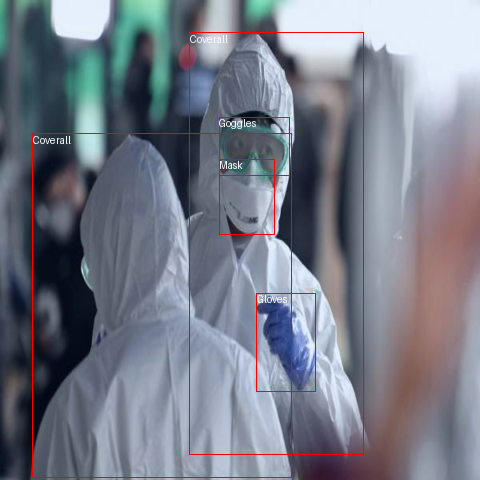

Image tensor shape: torch.Size([3, 480, 480])
Boxes shape: (2, 4)
Categories shape: (2,)


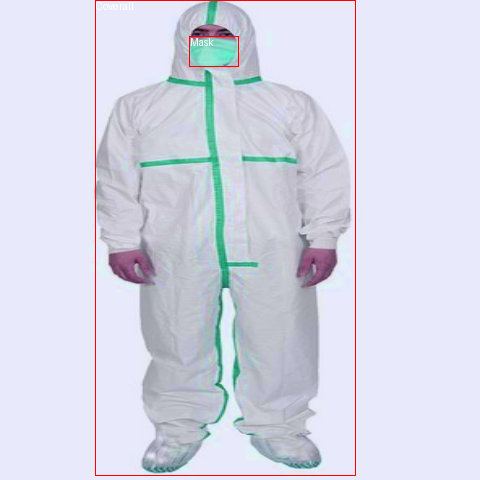

Image tensor shape: torch.Size([3, 480, 480])
Boxes shape: (4, 4)
Categories shape: (4,)


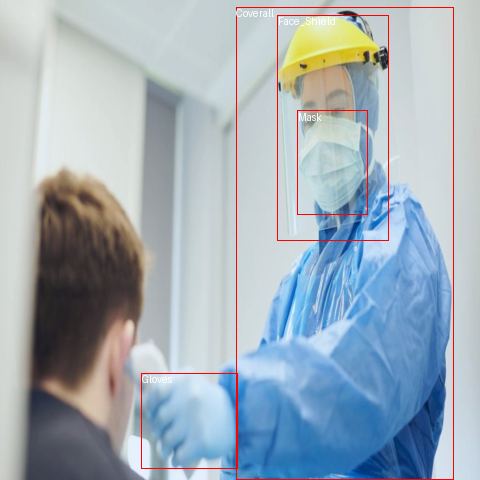

In [ ]:
for i in [15, 16, 17]:
    sample = train_dataset[i]

    # De-normalize image
    image = sample["pixel_values"]
    print("Image tensor shape:", image.shape)
    image = image.numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min()) * 255.
    image = Image.fromarray(image.astype(np.uint8))

    # Convert boxes from [center_x, center_y, width, height] to [x, y, width, height] for visualization
    boxes = sample["labels"]["boxes"].numpy()
    print("Boxes shape:", boxes.shape)
    boxes[:, :2] = boxes[:, :2] - boxes[:, 2:] / 2
    w, h = image.size
    boxes = boxes * np.array([w, h, w, h])[None]

    categories = sample["labels"]["class_labels"].numpy()
    print("Categories shape:", categories.shape)

    # Draw boxes and labels on image
    draw = ImageDraw.Draw(image)
    for box, category in zip(boxes, categories):
        x, y, w, h = box
        draw.rectangle([x, y, x + w, y + h], outline="red", width=1)
        draw.text((x, y), id2label[category], fill="white")

    display(image)

You have successfully augmented the images and prepared their annotations. In the final step, create a custom `collate_fn` to batch images together.

In [ ]:
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

## Preparing function to compute mAP

Object detection models are commonly evaluated with a set of <a href="https://cocodataset.org/#detection-eval">COCO-style metrics</a>. We are going to use `torchmetrics` to compute `mAP` (mean average precision) and `mAR` (mean average recall) metrics and will wrap it to `compute_metrics` function in order to use in [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) for evaluation.

Intermediate format of boxes used for training is `YOLO` (normalized) but we will compute metrics for boxes in `Pascal VOC` (absolute) format in order to correctly handle box areas. Let's define a function that converts bounding boxes to `Pascal VOC` format:

In [ ]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:
        boxes (torch.Tensor): Bounding boxes in YOLO format
        image_size (Tuple[int, int]): Image size in format (height, width)

    Returns:
        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)
    """
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

Then, in `compute_metrics` function we collect `predicted` and `target` bounding boxes, scores and labels from evaluation loop results and pass it to the scoring function.

In [ ]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, size in zip(target_batch, image_size_batch):
                boxes = torch.tensor(target["boxes"])
                boxes = convert_bbox_yolo_to_pascal(boxes, size)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=image_processor, threshold=0.01, id2label=id2label)

## Training the detection model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model!
The images in this dataset are still quite large, even after resizing. This means that finetuning this model will
require at least one GPU.

Training involves the following steps:
1. Load the model with [AutoModelForObjectDetection](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
2. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
3. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
4. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id`
and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DabDetrForObjectDetection were not initialized from the model checkpoint at davidhajdu/dab-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_embed.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_embed.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In the [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit. For `num_train_epochs=10` training will take about 15 minutes in Google Colab T4 GPU, increase the number of epoch to get better results.

Important notes:
 - Do not remove unused columns because this will drop the image column. Without the image column, you
can't create `pixel_values`. For this reason, set `remove_unused_columns` to `False`.
 - Set `eval_do_concat_batches=False` to get proper evaluation results. Images have different number of target boxes, if batches are concatenated we will not be able to determine which boxes belongs to particular image.

If you wish to share your model by pushing to the Hub, set `push_to_hub` to `True` (you must be signed in to Hugging
Face to upload your model).

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="dab-detr-r50-cppe5-finetune",
    num_train_epochs=40,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=8,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    report_to="tensorboard",  # or "wandb"
)

Finally, bring everything together, and call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    processing_class=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Coverall,Mar 100 Coverall,Map Face Shield,Mar 100 Face Shield,Map Gloves,Mar 100 Gloves,Map Goggles,Mar 100 Goggles,Map Mask,Mar 100 Mask
1,No log,1.310764,0.205800,0.436700,0.166000,0.114700,0.134300,0.396500,0.242900,0.390500,0.411200,0.175700,0.341900,0.640900,0.464400,0.609000,0.081800,0.463300,0.151500,0.314700,0.084000,0.312300,0.247300,0.356400
2,No log,1.369742,0.192900,0.416400,0.161000,0.073700,0.108400,0.358900,0.224000,0.376000,0.400000,0.184100,0.316900,0.622400,0.472300,0.597300,0.077400,0.457000,0.125100,0.269200,0.067100,0.326200,0.222700,0.350200
3,No log,1.421217,0.191000,0.413500,0.158400,0.065500,0.121400,0.334900,0.212100,0.369200,0.397400,0.156100,0.315700,0.602700,0.442400,0.588700,0.096900,0.426600,0.116500,0.267000,0.069000,0.369200,0.230000,0.335600
4,No log,1.472186,0.179600,0.397600,0.139400,0.048700,0.115100,0.339600,0.207500,0.356000,0.380600,0.218500,0.283600,0.598400,0.423700,0.564000,0.090900,0.434200,0.087800,0.224600,0.066900,0.355400,0.228400,0.324900
5,1.139100,1.475668,0.159800,0.363600,0.122000,0.046400,0.101100,0.301600,0.197000,0.331800,0.354700,0.143100,0.258800,0.574000,0.414500,0.565800,0.061000,0.396200,0.105100,0.262100,0.033100,0.255400,0.185100,0.294200
6,1.139100,1.448007,0.181800,0.400800,0.145200,0.045100,0.129700,0.333800,0.213700,0.362400,0.385300,0.140800,0.313400,0.577400,0.440400,0.585600,0.094500,0.426600,0.091700,0.254500,0.071100,0.353800,0.211200,0.306200
7,1.139100,1.383938,0.198800,0.419800,0.177400,0.070800,0.137700,0.347600,0.230300,0.379400,0.407700,0.170800,0.334700,0.616800,0.430200,0.584200,0.084100,0.445600,0.132100,0.300400,0.078300,0.361500,0.269000,0.346700
8,1.139100,1.324078,0.205300,0.454100,0.160200,0.064400,0.137900,0.373900,0.234400,0.389400,0.417000,0.171700,0.343800,0.624600,0.458100,0.609000,0.097100,0.464600,0.144400,0.305400,0.080500,0.358500,0.246600,0.347600
9,1.139100,1.343545,0.214200,0.461800,0.174800,0.074100,0.138100,0.392800,0.235400,0.391100,0.413900,0.178500,0.339800,0.638600,0.454700,0.603200,0.088400,0.444300,0.150400,0.308500,0.122500,0.363100,0.254900,0.350700
10,1.137600,1.334166,0.202100,0.431200,0.174600,0.069700,0.132800,0.382200,0.224800,0.378200,0.399400,0.213300,0.319800,0.606700,0.440200,0.586000,0.081400,0.397500,0.147400,0.320500,0.087400,0.335400,0.254300,0.357300


There were missing keys in the checkpoint model loaded: ['bbox_predictor.layers.0.weight', 'bbox_predictor.layers.0.bias', 'bbox_predictor.layers.1.weight', 'bbox_predictor.layers.1.bias', 'bbox_predictor.layers.2.weight', 'bbox_predictor.layers.2.bias'].


TrainOutput(global_step=2140, training_loss=1.0578893928884345, metrics={'train_runtime': 1885.1185, 'train_samples_per_second': 9.018, 'train_steps_per_second': 1.135, 'total_flos': 3.077303913216e+18, 'train_loss': 1.0578893928884345, 'epoch': 20.0})

## Evaluate

In [ ]:
from pprint import pprint

metrics = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="eval")
pprint(metrics)

{'epoch': 20.0,
 'eval_loss': 1.010949730873108,
 'eval_map': 0.3602,
 'eval_map_50': 0.6754,
 'eval_map_75': 0.3443,
 'eval_map_Coverall': 0.4986,
 'eval_map_Face_Shield': 0.3093,
 'eval_map_Gloves': 0.3217,
 'eval_map_Goggles': 0.2435,
 'eval_map_Mask': 0.428,
 'eval_map_large': 0.5495,
 'eval_map_medium': 0.2593,
 'eval_map_small': 0.3896,
 'eval_mar_1': 0.294,
 'eval_mar_10': 0.5339,
 'eval_mar_100': 0.5511,
 'eval_mar_100_Coverall': 0.7,
 'eval_mar_100_Face_Shield': 0.6647,
 'eval_mar_100_Gloves': 0.4203,
 'eval_mar_100_Goggles': 0.4724,
 'eval_mar_100_Mask': 0.498,
 'eval_mar_large': 0.7149,
 'eval_mar_medium': 0.4165,
 'eval_mar_small': 0.4621,
 'eval_runtime': 2.7545,
 'eval_samples_per_second': 10.528,
 'eval_steps_per_second': 1.452}


If you have set `push_to_hub` to `True` in the `training_args`, and you're authenticated with your Hugging Face token, the training checkpoints are pushed to the
Hugging Face Hub. Upon training completion, push the final model to the Hub as well by calling the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method.

In [ ]:
trainer.push_to_hub()

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/qubvel-hf/rtdetr-r50-cppe5-finetune/commit/e2f3f0322a20c0aca69af9244e3277b111794472', commit_message='End of training', commit_description='', oid='e2f3f0322a20c0aca69af9244e3277b111794472', pr_url=None, pr_revision=None, pr_num=None)

These results can be further improved by adjusting the hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). Give it a go!

## Inference

Now that you have finetuned a model, evaluated it, and uploaded it to the Hugging Face Hub, you can use it for inference.

In [ ]:
import torch
import requests
from PIL import Image, ImageDraw

device = "cuda"

url = "https://images.pexels.com/photos/8413299/pexels-photo-8413299.jpeg?auto=compress&cs=tinysrgb&w=630&h=375&dpr=2"
image = Image.open(requests.get(url, stream=True).raw)

Load model and image processor from the Hugging Face Hub (skip to use already trained in this session):

In [ ]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection

model_repo = "qubvel-hf/rtdetr-r50-cppe5-finetune"

image_processor = AutoImageProcessor.from_pretrained(model_repo)
model = AutoModelForObjectDetection.from_pretrained(model_repo)
model = model.to(device)

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

And detect bounding boxes:

In [ ]:
inputs = image_processor(images=[image], return_tensors="pt")
inputs = inputs.to(device)
with torch.no_grad():
    outputs = model(**inputs)
target_sizes = torch.tensor([image.size[::-1]])

result = image_processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Mask with confidence 0.811 at location [354.27, 153.48, 493.02, 286.46]
Detected Gloves with confidence 0.775 at location [424.15, 380.44, 583.71, 525.29]
Detected Gloves with confidence 0.702 at location [575.52, 291.57, 718.92, 427.88]
Detected Mask with confidence 0.464 at location [973.66, 16.78, 1089.36, 140.37]
Detected Coverall with confidence 0.311 at location [150.21, 289.37, 730.39, 750.0]


Let's plot the result:

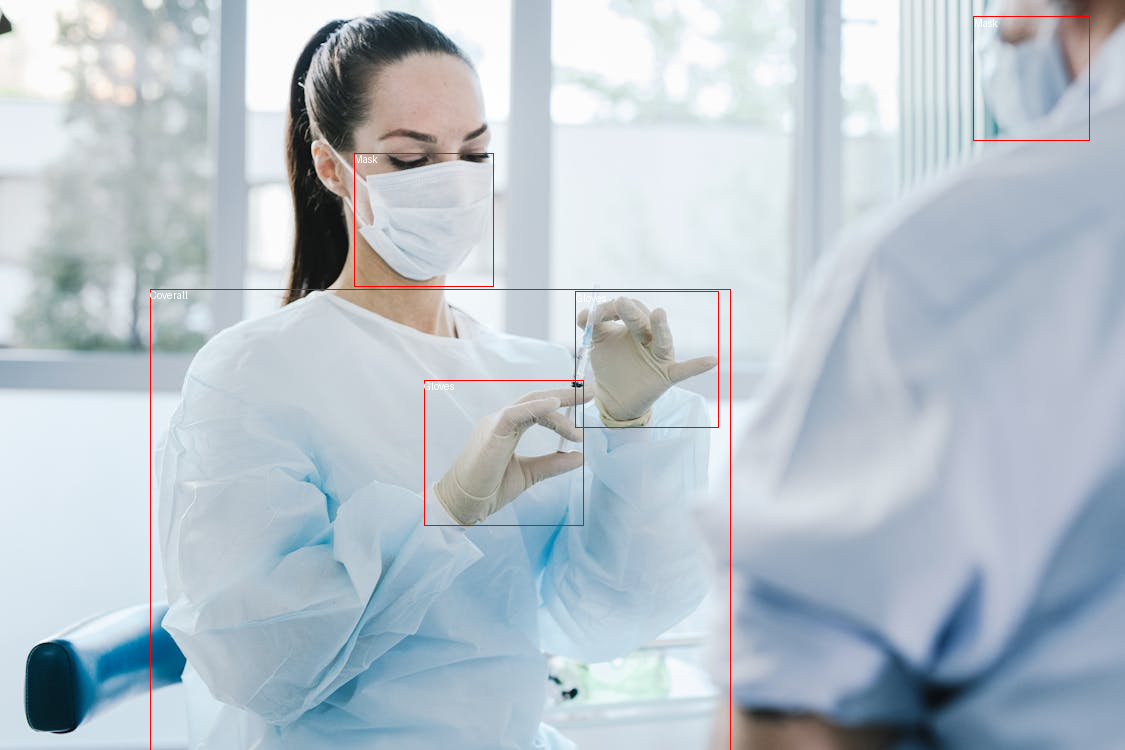

In [ ]:
image_with_boxes = image.copy()
draw = ImageDraw.Draw(image_with_boxes)

for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image_with_boxes